### Библиотеки

In [1]:
import pickle

In [2]:
# from importlib import reload
# import Experiment_6_part
# Experiment_6_part = reload(Experiment_6_part)
        
from Experiment_6_part2 import *

### Описание эксперимента:

### 0. Параметры для генерации данных

In [3]:
generate_flg=True # True - генерация, False - чтение уже сгенерированных

n=11 #число узлов
# n=51
L=1 # длина расчт области
T=.3 #конечное время
kurant=0.5

h=L/(n-1)
tau=kurant*(h**2)
b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
# IC
v=[0 for i in range(0,n)]
# v=np.abs(np.sin(np.linspace(0,np.pi,21)))
# BC
v[0]=0
v[-1]=1

In [4]:
epochs_lst=[10,100,1_000,5_000,10_000]
# epochs_lst=[1,100,1_000]

### 1. Генерация данных

In [5]:
CUSTOM_TAU=kurant*(h**2)
print('CUSTOM_TAU =',CUSTOM_TAU)
v_fact,x_lst,tau,time_lst=generate_data(generate_flg,v,T,L,0.5,h,n,CUSTOM_TAU=CUSTOM_TAU,save_flg=False)

CUSTOM_TAU = 0.005000000000000001
tau = 0.005000000000000001
Генерация данных
v_fact.shape = 11 61


Text(0.5, 1.0, 'Фактические данные')

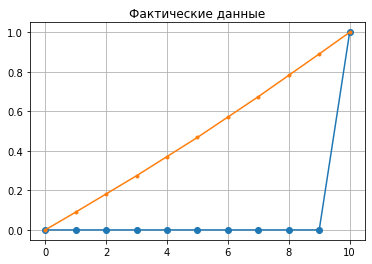

In [6]:
#view
plt.plot(v_fact[:,0],'o-')
plt.plot(v_fact[:,-1],'.-')
plt.grid()
plt.title('Фактические данные')

### 2. Сабсемплинг

In [7]:
t_factor = 1  # time subsample factor 
s_factor = 1  # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

full_sample (11, 61)
train (11, 30)
test (11, 31)


Text(0.5, 1.0, 'Фактические данные после сабсемплинга')

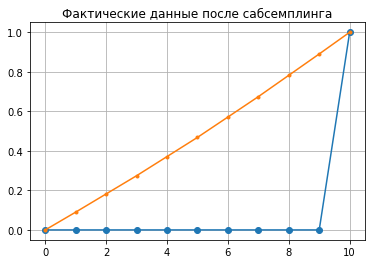

In [8]:
#view
plt.plot(v_coarse[:,0],'o-')
plt.plot(v_coarse[:,-1],'.-')
plt.grid()
plt.title('Фактические данные после сабсемплинга')

### 3. Тренировка модели

In [9]:
for epochs in epochs_lst:
    
    net, loss_lst,loss=train_net(MLPConv,v_coarse_train,epochs,dtc,
              fs,
              neurons,
              hidden_layers_num,
              lr,
              m,
              has_backward,
              method,
              decay_const
             )
    
    pickle.dump(net, open(fr'Experiment_6_part2/models/net_epochs={epochs}', 'wb'))
    

input 3 output 1
#parameters: 3


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 187.50it/s, loss=0.00128]


input 3 output 1
#parameters: 3


100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 259.50it/s, loss=0.00104]


input 3 output 1
#parameters: 3


100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.41it/s, loss=0.000356]


input 3 output 1
#parameters: 3


100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 152.13it/s, loss=0]


input 3 output 1
#parameters: 3


100%|███████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 144.67it/s, loss=0]


In [10]:
net.layer[0].weight

Parameter containing:
tensor([[ 100.0000, -200.0000,  100.0000]], requires_grad=True)

### 4. Симуляция прогноза моделью

In [11]:
NN_sim_lst=[]

weights=[]
biases=[]

for epochs in epochs_lst:
    
    net = pickle.load(open(fr'Experiment_6_part2/models/net_epochs={epochs}', 'rb'))
    
    NN_sim,T_sim,x_sim=make_simulation(net,v_coarse,L,Lxc,dtc,method='E1')
    
    NN_sim_lst.append(NN_sim)
    
    # print(fr'------Epochs = {epochs}------')
    # print(net.layer[0].weight)
    weights.append(net.layer[0].weight.data.numpy())
    biases.append(None)

100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 3836.43it/s]


In [12]:
pd.DataFrame({'epoch':epochs_lst+[['finite_diff_methods']],
              'coefs':weights+[[1/((dxc)**2),-2/(dxc**2),1/(dxc**2)]],
              'bias':biases+[[None]]})

,epoch,coefs,bias
0,10,"[[4.1501346, -5.9358172, 7.5102544]]",None
1,100,"[[-2.8203213, -13.027193, 16.02649]]",None
2,1000,"[[0.20280817, -74.12207, 59.80763]]",None
3,5000,"[[99.748024, -199.68323, 99.899376]]",None
4,10000,"[[99.99999, -200.00002, 99.99999]]",None
5,[finite_diff_methods],"[99.99999999999999, -199.99999999999997, 99.99...",[None]


### 5. Результаты

---------------Epochs = 10-------------------


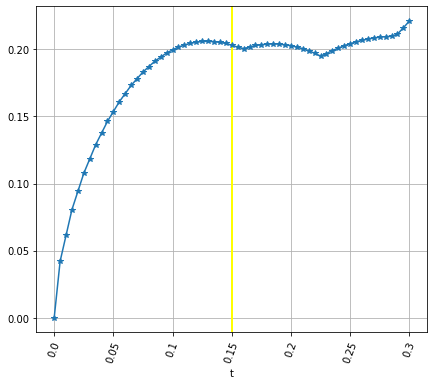



---------------Epochs = 100-------------------


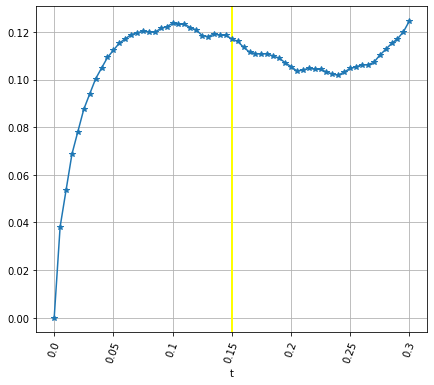



---------------Epochs = 1000-------------------


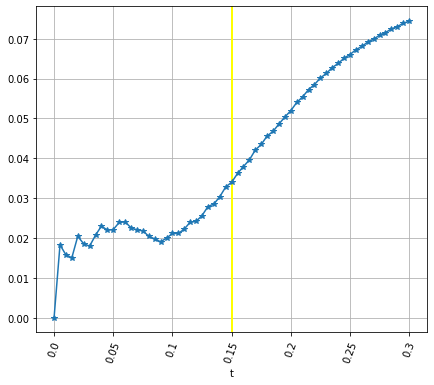



---------------Epochs = 5000-------------------


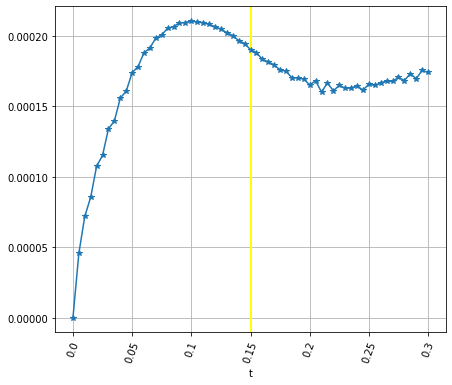



---------------Epochs = 10000-------------------


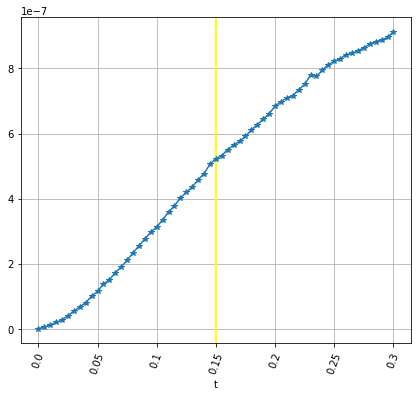

In [13]:
# view_results(T_sim,x_sim,NN_sim,v_coarse,T,dtc,n=10,fix_axes=True)

# view_result_imshow(NN_sim,v_coarse,T,dtc,L,dxc,figsize=(10,10))

folder='Experiment_6_part2'

for i in range(len(epochs_lst)):
    
    print(fr'---------------Epochs = {epochs_lst[i]}-------------------')
    view_results(T_sim,x_sim,NN_sim_lst[i],v_coarse,T,dtc,n=10,fix_axes=True,
                epochs=epochs_lst[i],
                save_path = fr'{folder}/graphs/',
                save_name = fr'Result_epoch={epochs_lst[i]}',
                view_flag=False)
    view_result_metric(NN_sim_lst[i],v_coarse,T,dtc,L,dxc,
                       n_xticks=10,
                       save_path = fr'{folder}/graphs/',
                save_name = fr'Metric_epoch={epochs_lst[i]}')

    make_gif(folder=fr'{folder}/graphs/',epochs=epochs_lst[i])

    print('\n')

In [14]:
net.layer[0].weight

Parameter containing:
tensor([[ 100.0000, -200.0000,  100.0000]], requires_grad=True)